In [587]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *

import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcdefaults()

In [588]:
DATA_FOLDER = "../Data/"

movies_imdb = pd.read_csv(DATA_FOLDER + 'movies_imdb.csv',
                          converters={'languages': parse_list, 'countries': parse_list, 'genresCmu': parse_list,
                                      'genresImdb': parse_list})

In [589]:
combinedGenres = movies_imdb.genresImdb.apply(
    lambda x: x if isinstance(x, list) else []
) + movies_imdb.genresCmu.apply(lambda x: x if isinstance(x, list) else [])

combinedGenres = combinedGenres.apply(lambda x: set(x) if len(x)>0 else np.nan)

movies_imdb["combinedGenres"]= combinedGenres

In [590]:
genres = movies_imdb.dropna(subset="combinedGenres").explode(column="combinedGenres").combinedGenres.values
genres_unique = np.unique(genres)


In [591]:
genres_str = " ".join(str(g) for g in genres)

In [592]:
split_characters = set()
for m in genres_str:
    for l in m:
        if not l.isalpha() and l != " ":
            split_characters.add(l)

split_characters

{'&', "'", '-', '/', '5', '9', '[', ']'}

In [593]:
string = genres_str
for delimiter in split_characters:
    string = " ".join(string.split(delimiter))
    
words = string.split(" ")

In [594]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

words = list(map(lambda x: x.lower(), words)) #tout en minuscule
words = list(map(lambda x:lemmatizer.lemmatize(x), words)) #enlever les s
ags = nltk.pos_tag(words) # dire si c'est un verbe adjectif etc
words_, tags= np.array(list(map(list, zip(*ags))))

In [595]:
mask = (tags == np.array(["NN","NNS","NNP","NNPS","JJ"]).reshape(-1,1)).any(axis=0) # grader que les nouns et les adjs


In [596]:
counts = pd.Series(words_[mask]).value_counts()
themes = pd.Series(counts[counts > 2000]).index
themes 

Index(['drama', 'film', 'comedy', 'action', 'romance', 'thriller', 'crime',
       'adventure', 'fiction', 'short', 'black', 'white', 'family', 'cinema',
       'world', 'movie', 'indie', 'horror', 'romantic', 'documentary',
       'silent', 'musical', 'fantasy', 'animation', 'mystery', 'war', '',
       'science', 'western', 'japanese', 'biography'],
      dtype='object')

In [597]:
themes = list(themes)
to_remove = [
    "", #remove null caracter 
    "film",
    "cinema",
    "movie",  # comes from genres like "Romance Film" not a genre in itself.
    "black",
    "white",  # will add "black-and-white" instead of having both
]
for r in to_remove:
    themes.remove(r)
themes.append("black-and-white")

In [598]:
genres_dict = {theme: set() for theme in themes}
for theme in themes:
    for genre in genres_unique:
        if theme in genre.lower():
            genres_dict[theme].add(genre)


genres_dict["romance"]= genres_dict["romance"].union(genres_dict.pop("romantic"));
themes.remove("romantic")

print(len(themes) ,"themes :",themes)

25 themes : ['drama', 'comedy', 'action', 'romance', 'thriller', 'crime', 'adventure', 'fiction', 'short', 'family', 'world', 'indie', 'horror', 'documentary', 'silent', 'musical', 'fantasy', 'animation', 'mystery', 'war', 'science', 'western', 'japanese', 'biography', 'black-and-white']


In [599]:
def unify_genres(x):
    try:
        unified_genres = set()
        for genre in x:
            themes_in_genres = {t for t in themes if genre in genres_dict[t]}
            unified_genres= unified_genres.union(themes_in_genres)
        return unified_genres if unified_genres else np.nan

    except TypeError: 
        return x
        

In [600]:
genres_final = movies_imdb.combinedGenres.apply(unify_genres)
(genres_final.isnull()).sum()

3337

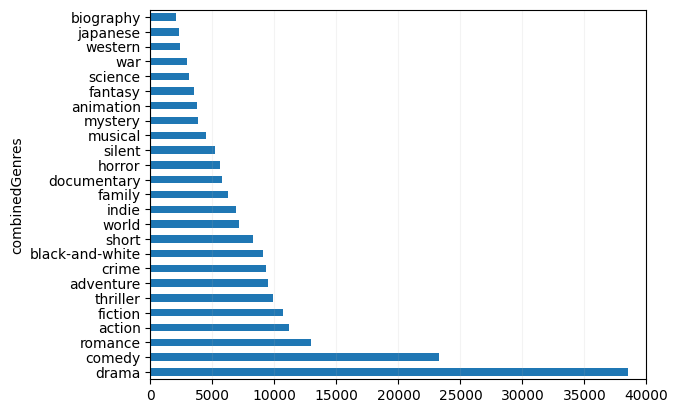

In [606]:
genres_final.explode().value_counts().plot(kind='barh')
plt.xlim([0,4e4])
plt.grid(alpha=0.15, axis="x")

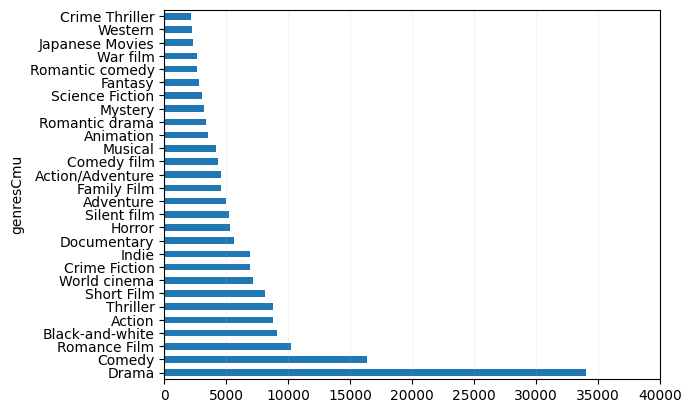

In [607]:
occurences = movies_imdb.genresCmu.explode().value_counts()
occurences[occurences>2000].plot(kind='barh')
plt.xlim([0,4e4])
plt.grid(alpha=0.15, axis="x")